In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [3]:
class OptLog():
    def __init__(self, init_param, init_cost):
        self.init_param = init_param
        self.init_cost = init_cost
        self.hist = np.array([[self.init_param, self.init_cost]])
    def update(self, param, cost):
        self.hist = np.append(self.hist, [[param, cost]], axis=0)
    def print(self):
        print("Param | Cost")
        print(self.hist)
    def plot(self):
        fig, [ax1, ax2] = plt.subplots(1, 2)

        ax1.plot(range(self.hist.shape[0]), self.hist[:,1], "go", ls="dashed")
        ax1.set_xlabel("Optimization step", fontsize=13)
        ax1.set_ylabel("Energy (Hartree)", fontsize=13)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        ax2.plot(range(self.hist.shape[0]), self.hist[:,0], "go", ls="dashed")
        ax2.set_xlabel("Optimization step", fontsize=13)
        ax2.set_ylabel("Gate parameter $\\theta$ (rad)", fontsize=13)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        return fig

In [5]:
symbols = ['H', 'H']
coordinates = np.array([0.0, 0.0, -0.6614, 0.0, 0.0, 0.6614])
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates)

In [6]:
dev = qml.device("default.qubit", wires=qubits)
electrons = 2
hf = qml.qchem.hf_state(electrons, qubits)
def circuit(param, wires):
    qml.BasisState(hf, wires=wires)
    qml.DoubleExcitation(param, wires=[0, 1, 2, 3])

In [7]:
@qml.qnode(dev)
def cost_fn(param):
    circuit(param, wires=range(qubits))
    return qml.expval(H)
# print(qml.draw(cost_fn)(2))

0: ─╭BasisState(M0)─╭G²(2.00)─┤ ╭<𝓗>
1: ─├BasisState(M0)─├G²(2.00)─┤ ├<𝓗>
2: ─├BasisState(M0)─├G²(2.00)─┤ ├<𝓗>
3: ─╰BasisState(M0)─╰G²(2.00)─┤ ╰<𝓗>


In [8]:
opt = qml.GradientDescentOptimizer(stepsize=0.4)

Step = 0,  Energy = -1.12799983 Ha
Step = 1,  Energy = -1.13264901 Ha
Step = 2,  Energy = -1.13466246 Ha
Step = 3,  Energy = -1.13553146 Ha
Step = 4,  Energy = -1.13590595 Ha
Step = 5,  Energy = -1.13606723 Ha
Step = 6,  Energy = -1.13613667 Ha
Step = 7,  Energy = -1.13616657 Ha
Step = 8,  Energy = -1.13617944 Ha
Step = 9,  Energy = -1.13618498 Ha
Step = 10,  Energy = -1.13618736 Ha
Step = 11,  Energy = -1.13618839 Ha
Step = 12,  Energy = -1.13618883 Ha

Final value of the ground-state energy = -1.13618883 Ha

Optimal value of the circuit parameter = 0.2089


/tmp/ipykernel_4819/1352419029.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  log.plot().show()


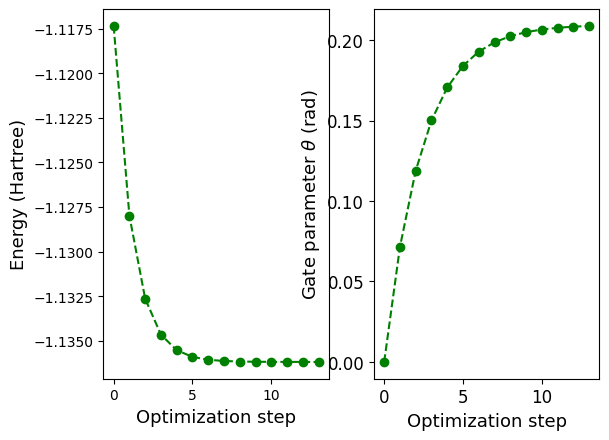

In [9]:
theta = np.array(0.0, requires_grad=True)
log = OptLog(theta, cost_fn(theta))

max_iterations = 100
conv_tol = 1e-06
epsilon = 0

for n in range(max_iterations):
    theta1, prev_energy = opt.step_and_cost(cost_fn, theta)
    theta = theta1 + np.random.normal(0, epsilon)

    log.update(theta, cost_fn(theta))
    energy = log.hist[:, 1]
    angle = log.hist[:, 0]

    conv = np.abs(energy[-1] - prev_energy)
    print(f"Step = {n},  Energy = {energy[-1]:.8f} Ha")

    if conv <= conv_tol:
        break

print("\n" f"Final value of the ground-state energy = {energy[-1]:.8f} Ha")
print("\n" f"Optimal value of the circuit parameter = {angle[-1]:.4f}")
log.plot().show()